# 

<img align="left" src = https://linea.org.br/wp-content/themes/LIneA/imagens/logo-header.jpg width=100 style="padding: 20px"> 

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=160 style="padding: 20px">  

# QA DP0.2 - TRAINING

**Contact author**: Heloisa da Silva Mengisztki ([heloisasmengisztki@gmail.com](mailto:heloisasmengisztki@gmail.com)) 

**Last verified run**: 2023-05-01 (YYYY-MM-DD) <br><br><br>

This notebook is a quality analysis of the dp0.2 data.


## CONTINUAR - O QUE AINDA NÃO TEM AQUI :) 

Descrever as coisas

Descrever como foi feito o training set e test set (esse ainda n tem)

Plots e métricas de qualidade:
- Métricas de treinamento eficaz (Evaluate do rail)
Plotzinho de bias, etc



## Imports

In [88]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io

from datetime import datetime

pd.set_option('display.max_rows', 20)
CURR_DIR =  os.getcwd()

%matplotlib inline

### Tap service

In [ ]:
from lsst.rsp import get_tap_service

service = get_tap_service()

assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

For this step, we are going to read 1k of galaxies, the, we are going to use it to try running bpz_rail. Here we are going to use some values present in the TAP tutorial notebook from rubin science platform for coordenates and radius. 

In [ ]:
max_rec = 1000
use_center_coords = "62, -37"
use_radius = "1.0"

In [ ]:
bands = ['g', 'i', 'r', 'u', 'y', 'z']

mags = ""
for band in bands:
    mags+= f"scisql_nanojanskyToAbMag({band}_cModelFlux) AS mag_{band}_cModel, {band}_cModelFluxErr, "

columns_query = f"objectId, {mags}coord_ra, coord_dec "

In [ ]:
query = "SELECT " + columns_query + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 " + \
        "AND r_extendedness = 1 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) > 17.0 " + \
        "AND scisql_nanojanskyToAbMag(r_cModelFlux) < 23.0 "
print(query)

In [ ]:
%%time
results = service.search(query, maxrec=max_rec)
print(type(results))
results = results.to_table()
print(type(results))
results_pd = results.to_pandas()
results_pd.info(memory_usage="deep")

results_pd.head()

## Métricas base

População: nesse caso a população seria todos os dados que são galáxias coletados pelo Blanco telescópio, toda a base de dados

Amostra: nesse caso pode ser ou o arquivo que vamos ler direto do diretório ou os dados do TAP ou a amostra definida pela Melissa

Variáveis: nesse caso seriam as características por exemplo no TAP de limite de banda

#### Medidas de tendência central

Média - valor que representa o “meio” dos dados

Mediana - o meio de um conjunto organizado 

Moda - o número que mais se repete no conjunto

## BINS

In [ ]:
t0_t1_tests = ["" ] 

In [ ]:
	Test name (process ID)	Desctiption	PZ algorithm	Input data	Output size (GB)
1	test_fzboost_50_files	Test linearity 	FlexZBoost	50 original files 	201
2	test_fzboost_100_files	Test linearity 	FlexZBoost	100 original files 	402
3	test_fzboost_150_files	Test linearity 	FlexZBoost	150 original files 	601
4	test_fzboost_2x_files	Test linearity 	FlexZBoost	2x original files 	1254
5	test_bpz_50_files	Test linearity 	BPZ	50 original files 	203
6	test_bpz_100_files	Test linearity 	BPZ	100 original files 	406
7	test_bpz_150_files	Test linearity 	BPZ	150 original files 	607
8	test_bpz_2x_files	Test linearity 	BPZ	2x original files 	1254

## Linearidade BPZ

In [110]:
df = pd.read_csv(f"{CURR_DIR}/results/results_1.csv")
df

,comment,process_id,start,end,duration,user,file_path
0,teste para 150 arquivos originais em nodes imp...,test_bpz_150_files,1900-07-14 15:56:01,1900-07-14 16:04:23,0:26:24,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
1,teste para 150 arquivos originais em nodes imp...,test_fzboost_150_files,1900-07-14 17:08:00,1900-07-14 17:11:06,0:30:26,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
2,teste para 2x todos os arquivos originais em n...,test_bpz_2x_files,1900-07-15 01:17:11,1900-07-15 01:20:48,0:42:52,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
3,teste para 50 arquivos originais em nodes impa...,test_bpz_50_files,1900-07-14 01:39:36,1900-07-14 01:43:10,0:07:52,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
4,teste para 2x todos os arquivos originais em n...,test_fzboost_2x_files,1900-07-14 18:35:55,1900-07-14 18:38:55,0:57:25,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
5,teste para 50 arquivos originais em nodes impa...,test_fzboost_50_files,1900-07-14 00:52:27,1900-07-14 00:55:23,0:11:07,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
6,teste para 100 arquivos originais em nodes imp...,test_bpz_100_files,1900-07-14 02:21:02,1900-07-14 02:24:36,0:14:48,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...
7,teste para 100 arquivos originais em nodes imp...,test_fzboost_100_files,1900-07-14 01:52:16,1900-07-14 01:55:16,0:24:47,heloisa.mengisztki,/lustre/t0/scratch/users/heloisa.mengisztki/te...


In [108]:
linearity_tests_bpz = ["test_bpz_2x_files", "test_bpz_150_files", "test_bpz_100_files", "test_bpz_50_files"]
linearity_tests_fzb = ["test_fzboost_2x_files", "test_fzboost_150_files", "test_fzboost_100_files", "test_fzboost_50_files" ]

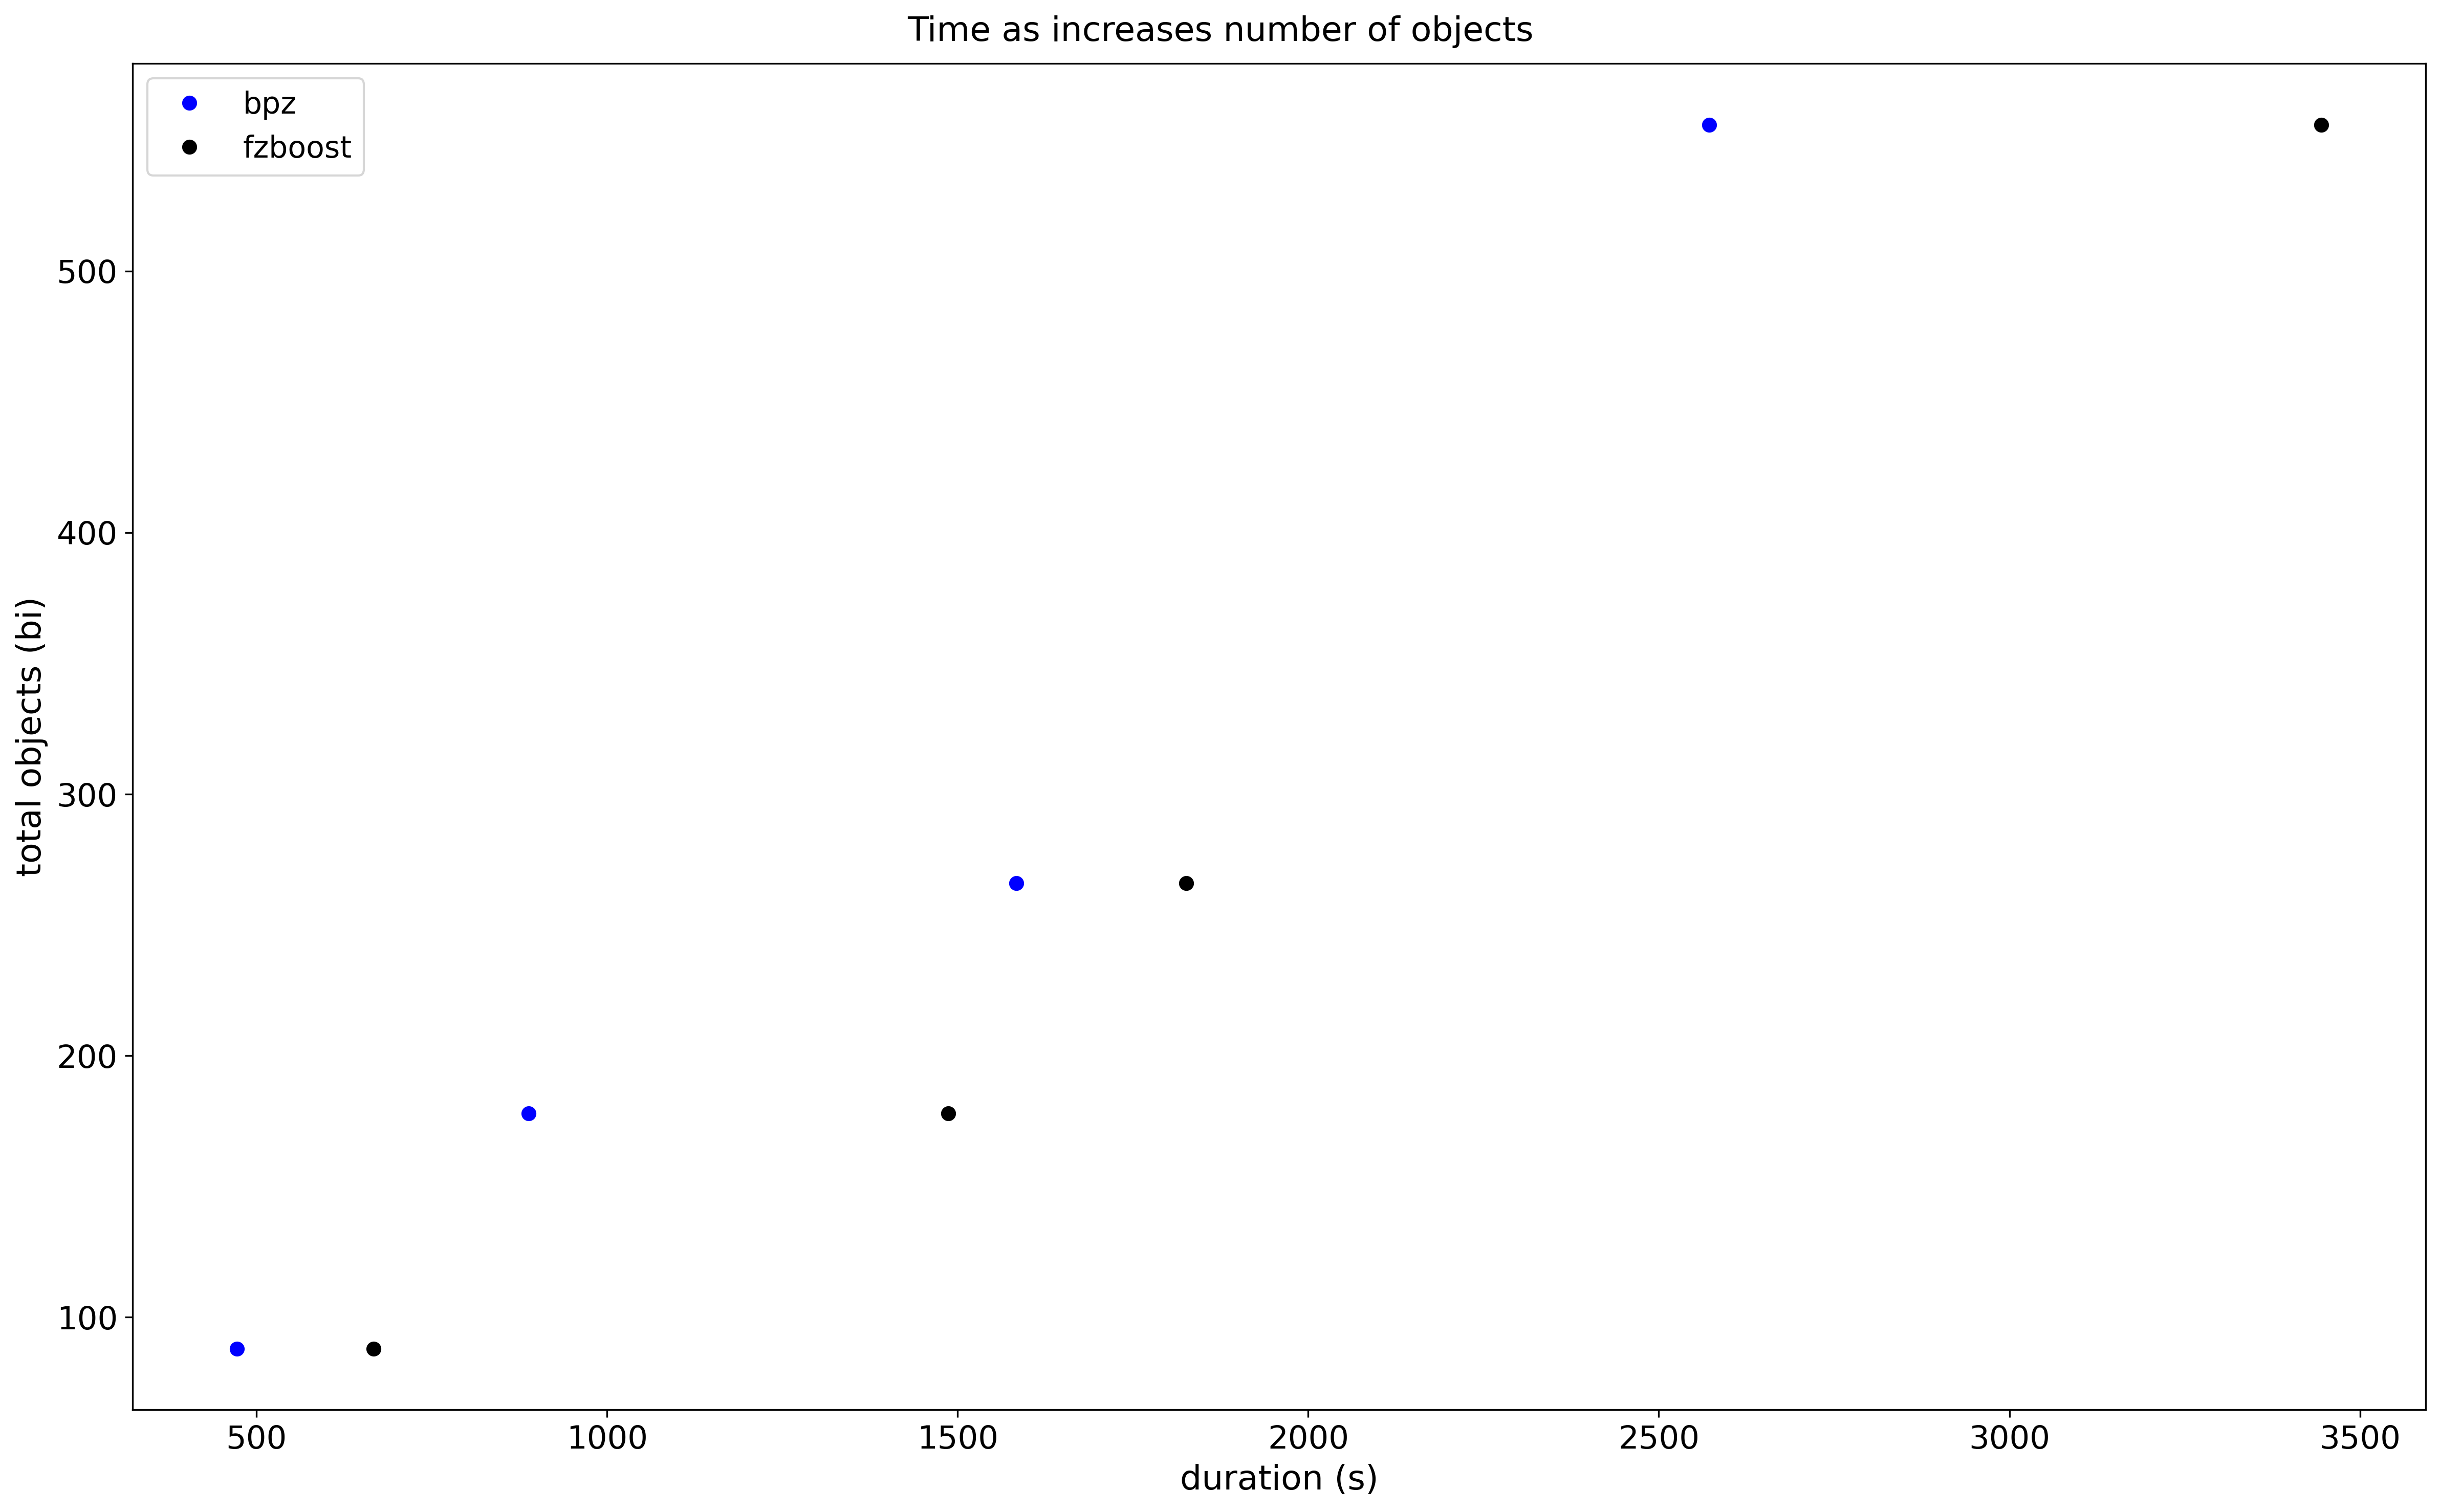

In [156]:
total_time_bpz = []
total_rows_bpz = []

total_time_fzb = []
total_rows_fzb = []

df = pd.read_csv(f"{CURR_DIR}/results/results_1.csv")
dictionary = df.set_index('process_id')['duration'].to_dict()

def time_and_rows(test):
    duration_string = dictionary[test]
    datetime_obj = datetime.strptime(duration_string, '%H:%M:%S')
    duration = datetime_obj.hour * 3600 + datetime_obj.minute * 60 + datetime_obj.second
    
    df_process = pd.read_csv(f"{CURR_DIR}/results/tests/{test}.csv")
    rows = df_process["chunks"].sum()//1000000
    #print(test, duration, rows)
    
    return duration, rows

for test in linearity_tests_bpz:
    rows, time = time_and_rows(test)
    total_time_bpz.append(rows)
    total_rows_bpz.append(time)

for test in linearity_tests_fzb:
    rows, time = time_and_rows(test)
    total_time_fzb.append(rows)
    total_rows_fzb.append(time)

plt.figure(figsize=[16,10], dpi=300)
plt.suptitle("Time as increases number of objects", fontsize=16)

plt.plot(total_time_bpz, total_rows_bpz, f"bo", label="bpz", alpha=1)
plt.plot(total_time_fzb, total_rows_fzb, f"ko", label="fzboost", alpha=1)

plt.xlabel(f"duration (s)", fontsize=16)
plt.ylabel("total objects (bi)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 14})

plt.tight_layout()

255.63204134366924 64.75113706388287
328.68679245283016 155.1668083634503
261.19292604501607 68.88848414931442
248.10645161290321 76.12400577717314


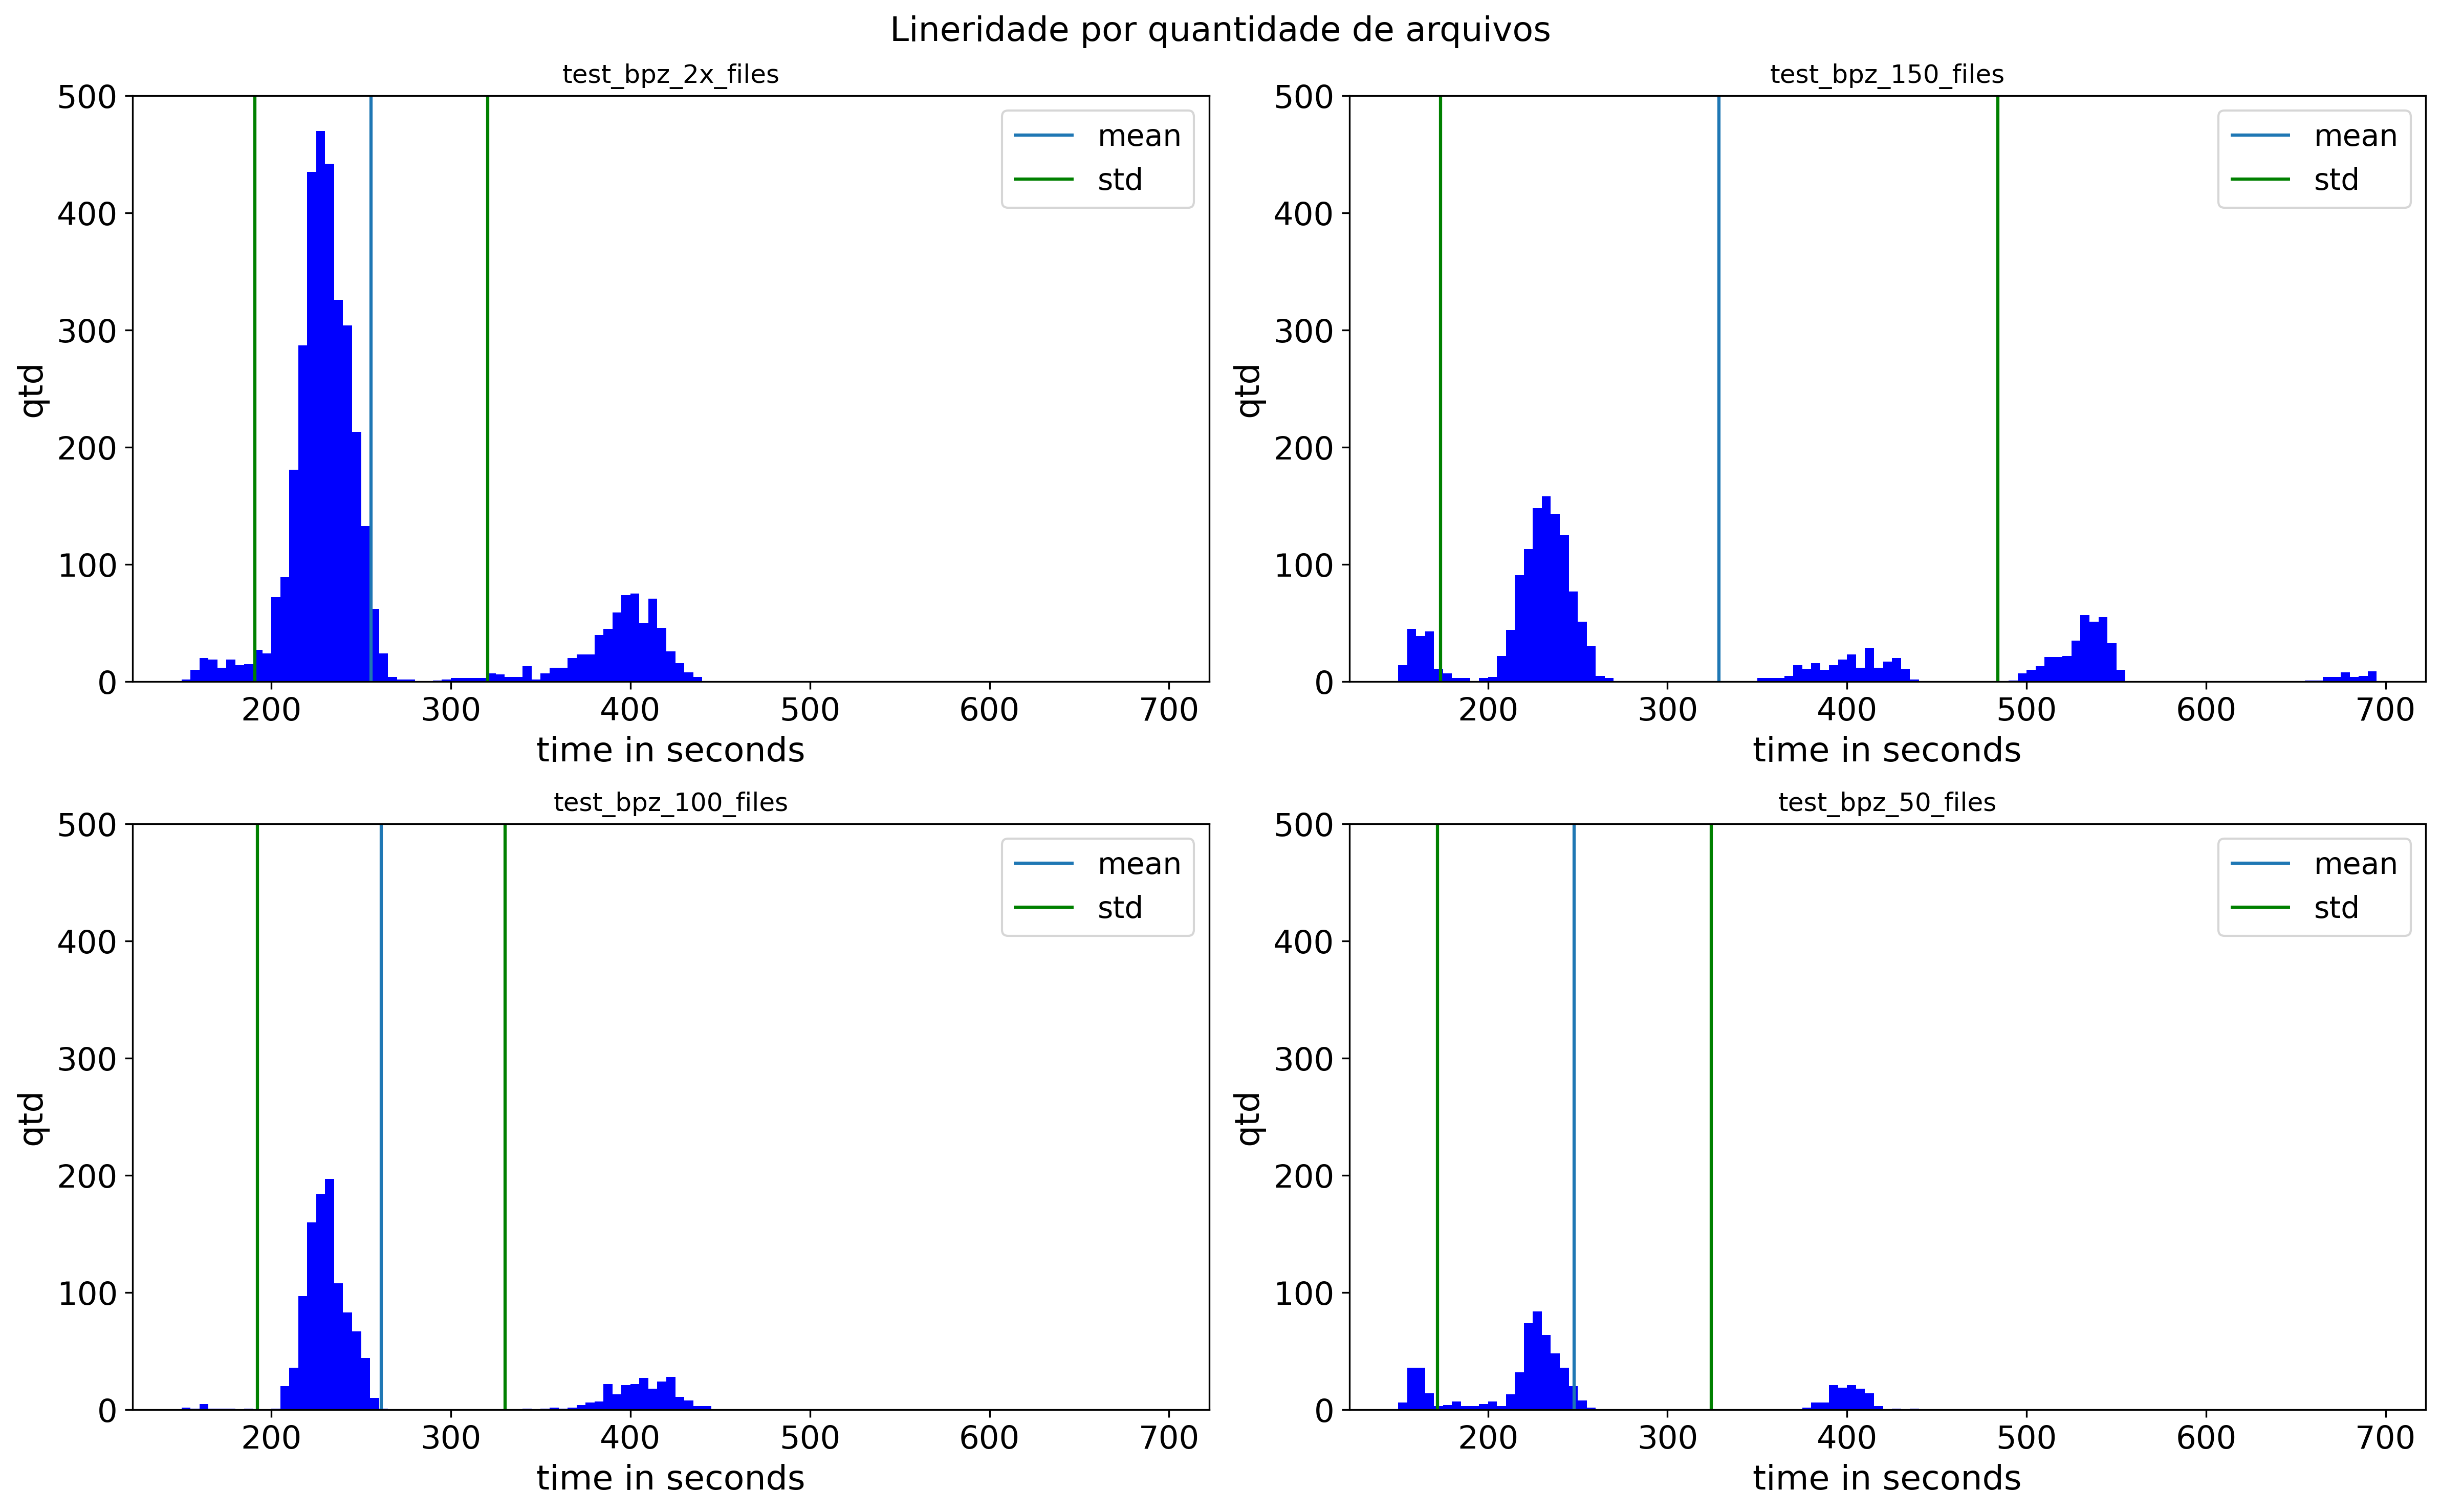

In [161]:
plt.figure(figsize=[16,10], dpi=300)
plt.suptitle("Lineridade por quantidade de arquivos", fontsize=16)

pos_grafico = 1

def monta_grafico_hist(pos, df, test):
    plt.subplot(2,2,pos)
    plt.hist(df["time_diff"], bins=np.arange(150,700,5), color="b")
    plt.title(test)
    plt.xlabel(f"time in seconds", fontsize=16)
    plt.ylabel("qtd", fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    mean = df["time_diff"].mean()
    std = df["time_diff"].std()
    
    plt.vlines(mean, 0, 500, label="mean")
    plt.vlines(mean-std, 0, 500, color="g", label="std")
    plt.vlines(mean+std, 0, 500, color="g")
    plt.ylim(0, 500)
    
    plt.legend(prop={'size': 14})
    plt.tight_layout()


for test in linearity_tests_bpz:
    df = pd.read_csv(f"{CURR_DIR}/results/tests/{test}.csv")
    monta_grafico_hist(pos_grafico, df, test)
    pos_grafico = pos_grafico + 1

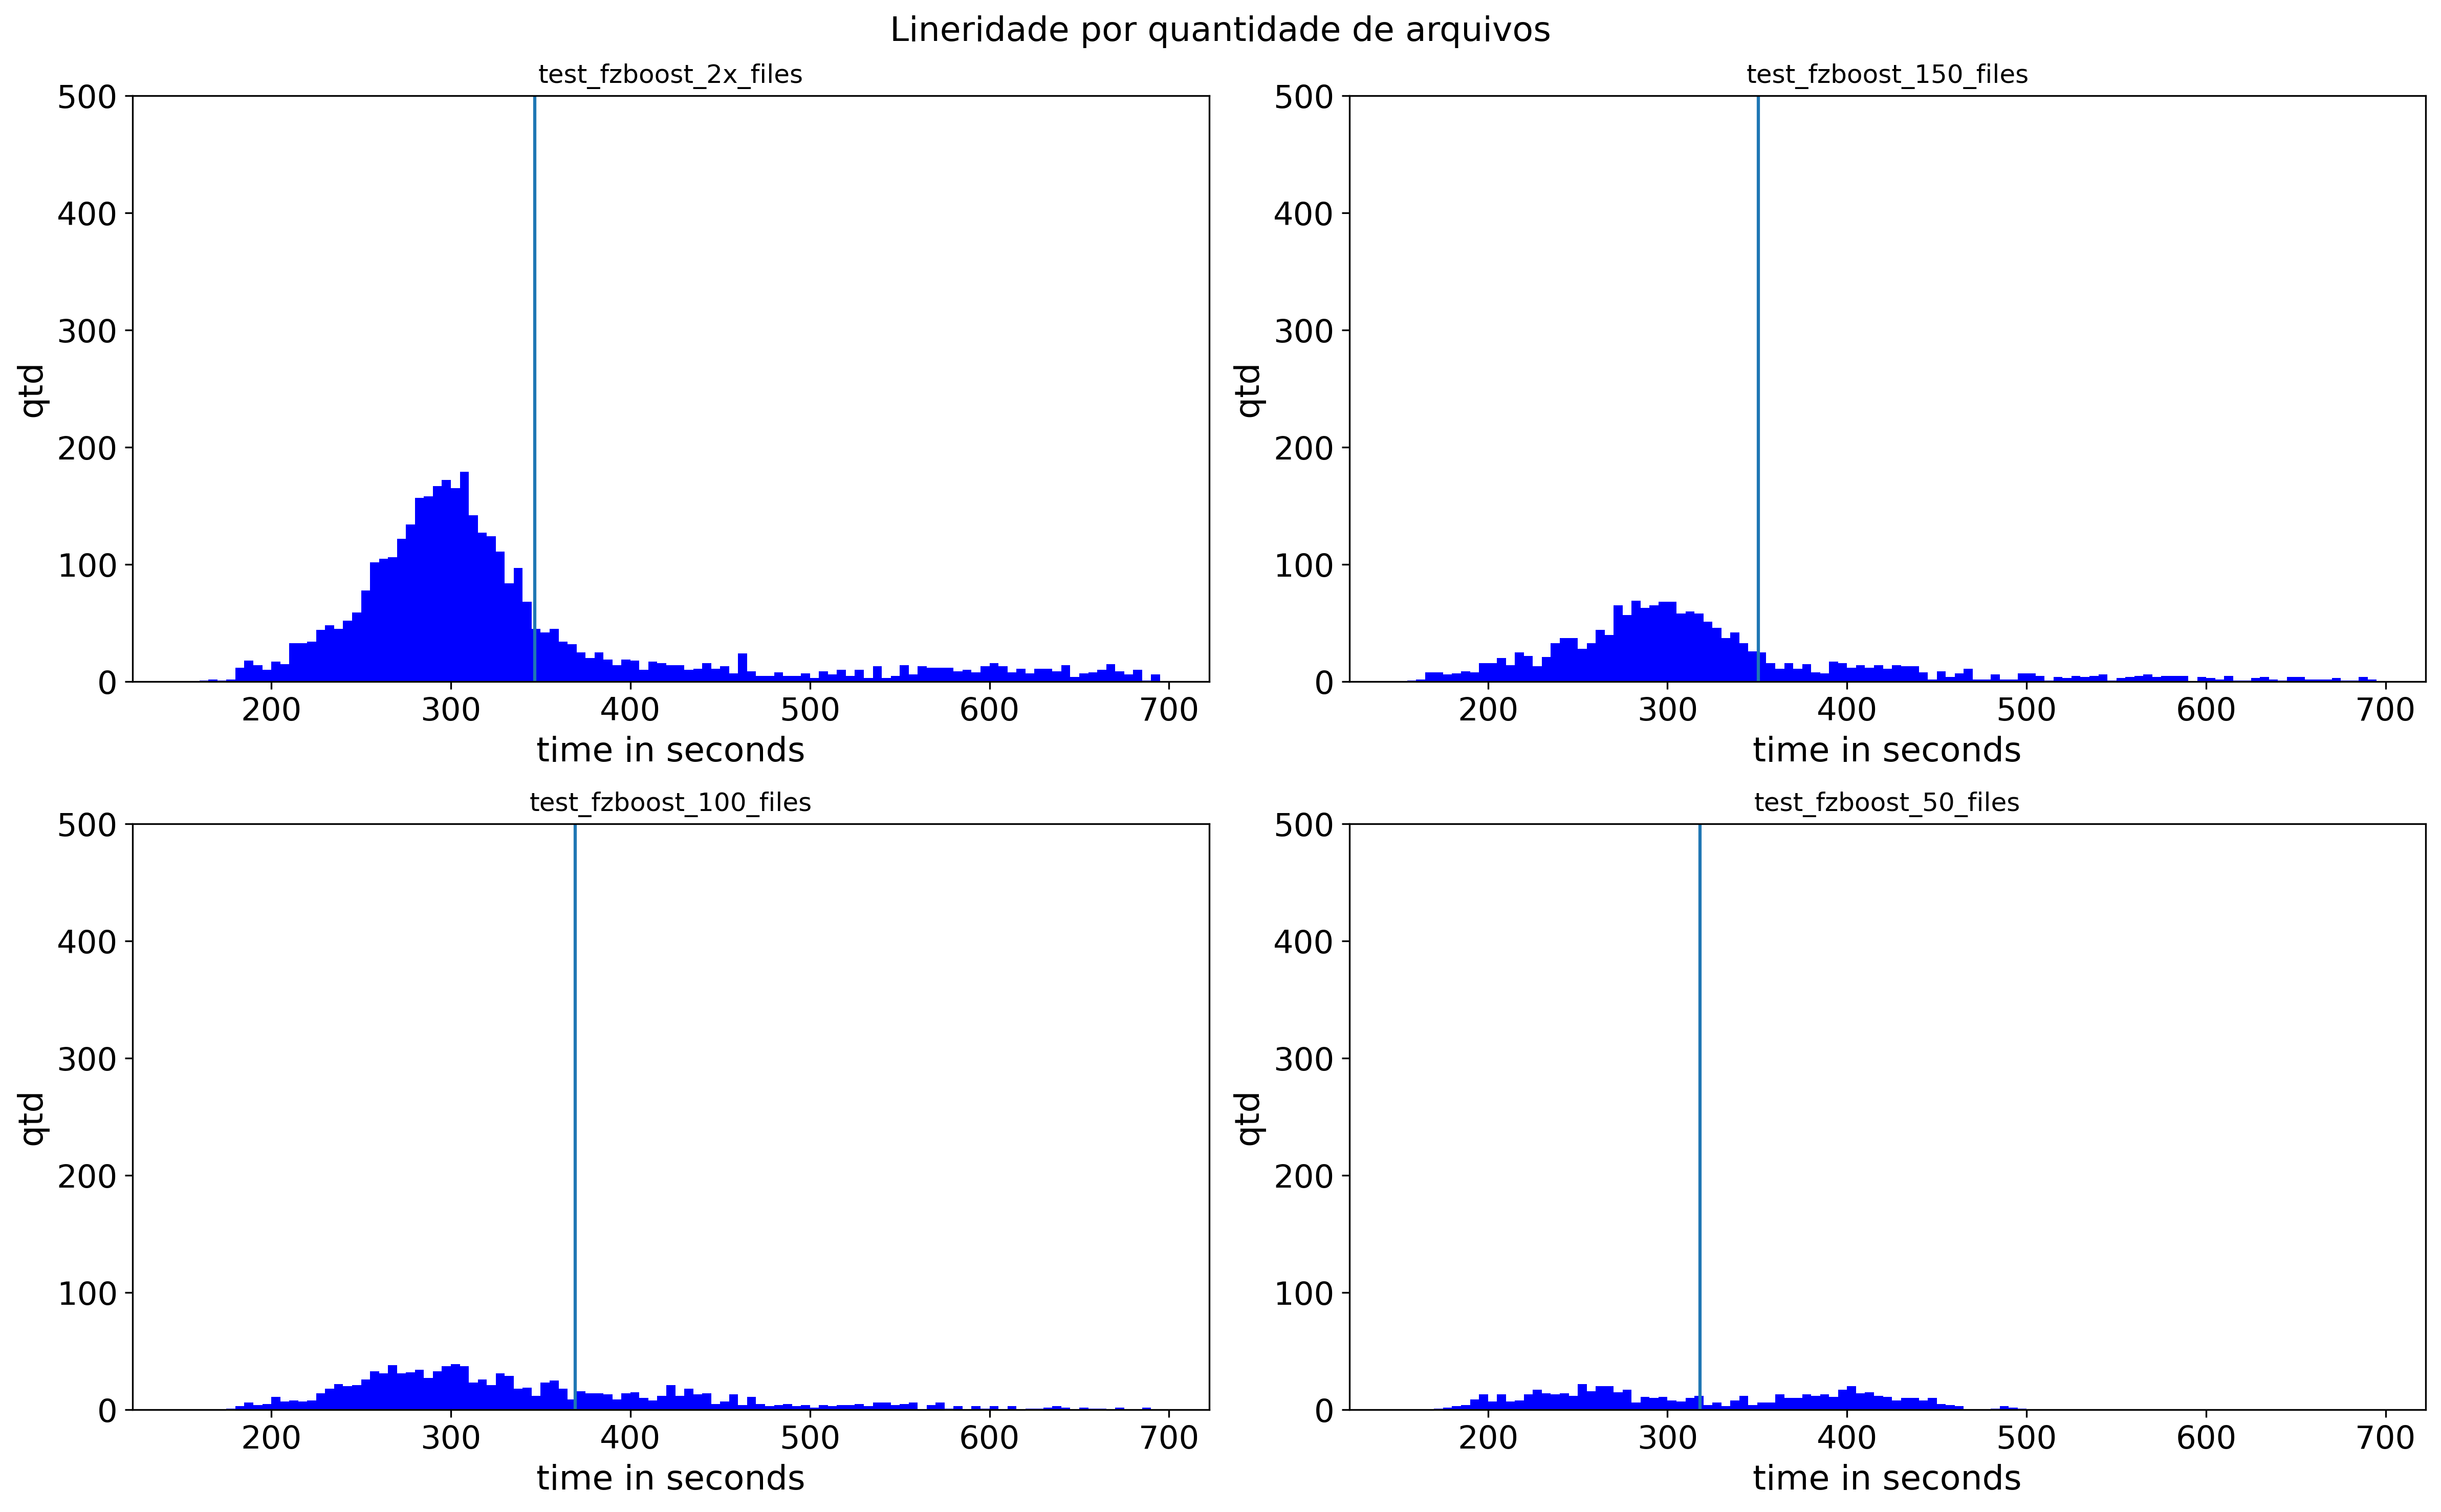

In [153]:
plt.figure(figsize=[16,10], dpi=300)
plt.suptitle("Lineridade por quantidade de arquivos", fontsize=16)

pos_grafico = 1

for test in linearity_tests_fzb:
    df = pd.read_csv(f"{CURR_DIR}/results/tests/{test}.csv")
    monta_grafico_hist(pos_grafico, df, test)
    pos_grafico = pos_grafico + 1

## T0 e T1